## Factors Affecting Bird Behaviour - Multinomial Logistic Regression Modelling in Python

***NOTE: In order for this notebook to work you will need to replace the file paths Path and Path2 with the file directories on your device of the CSV files downloaded from the Bird Regression Data GitHub repository.***

### Introduction

As part of a university field trip to the Silverdale Area of Outstanding Natural Beauty, our cohort collected data about bird behaviour at two sites at various times of day. You can view the data itself in the CSV files in the [Bird Data Regression repository on my GitHub](https://github.com/LukeNash28/Bird-Data-Regression) along with a README with more information.

Given the data I had available I decided to assess whether the location or the time affected bird behaviour activity. I decided to build a multinomial logistic regression model, with Location and Time predicting the Activity.

### Data Preparation

First let's import the packages and functions we need to complete this analysis.

In [40]:
import pandas as pd
import numpy as np
import requests
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sns.set(style="white")
sns.set(style="whitegrid", color_codes="True")

Now let's import the data.

In [4]:
Path="/Users/lukenash1/Documents/Finance/Projects/Bird Data Regression/Lancs Behaviour Data Collated.csv"
df=pd.read_csv(Path)
df=pd.DataFrame(df)
print(df)

     Helper   Time     Period Location  \
0         1  12:27     Midday       LM   
1         2  12:27     Midday       LM   
2         3  12:12     Midday       LM   
3         4  11:55     Midday       LM   
4         5  12:00     Midday       LM   
..      ...    ...        ...      ...   
511     512  12:11     Midday       EW   
512     513  15:28  Afternoon       EW   
513     514  15:20  Afternoon       EW   
514     515  15:40  Afternoon       EW   
515     516  12:10     Midday       EW   

    Species (common name as in the species list in the module guide - p25)  \
0                                              Bittern                       
1                                              Bittern                       
2                                              Bittern                       
3                                              Bittern                       
4                                              Bittern                       
..                         

The data cleaning that was done within Excel is described in the README, but we can now do some further cleaning here.

In [60]:
#Rename columns
new_col_names = {"Species (common name as in the species list in the module guide - p25)":"Species",
                 "Activity (travelling; foraging; resting)":"Activity"}
df.rename(columns= new_col_names, inplace=True)

#Remove helper and unnamed column
df_clean= df.drop(df.columns[[0,7]],axis=1)

print(df_clean)

      Time     Period Location  Species         Family    Activity
0    12:27     Midday       LM  Bittern       Ardeidae  Travelling
1    12:27     Midday       LM  Bittern       Ardeidae  Travelling
2    12:12     Midday       LM  Bittern       Ardeidae  Travelling
3    11:55     Midday       LM  Bittern       Ardeidae  Travelling
4    12:00     Midday       LM  Bittern       Ardeidae  Travelling
..     ...        ...      ...      ...            ...         ...
511  12:11     Midday       EW     Wren  Troglodytidae    Foraging
512  15:28  Afternoon       EW     Wren  Troglodytidae     Resting
513  15:20  Afternoon       EW     Wren  Troglodytidae    Foraging
514  15:40  Afternoon       EW     Wren  Troglodytidae     Resting
515  12:10     Midday       EW     Wren  Troglodytidae  Travelling

[516 rows x 6 columns]


The research question doesn't focus on species or species family, so we can drop those temporarily, and the time period can be removed for the time being as well. However, I'd like to keep these so we can reintegrate them into the analysis later, should our model prove insufficient.

In [61]:
#Drop columns

cols= df_clean.columns #Needed for reindexing later, if necessary

df_removed_cols= pd.concat([df_clean.pop(x) for x in ['Period','Species','Family']],axis=1)
print(df_clean)

      Time Location    Activity
0    12:27       LM  Travelling
1    12:27       LM  Travelling
2    12:12       LM  Travelling
3    11:55       LM  Travelling
4    12:00       LM  Travelling
..     ...      ...         ...
511  12:11       EW    Foraging
512  15:28       EW     Resting
513  15:20       EW    Foraging
514  15:40       EW     Resting
515  12:10       EW  Travelling

[516 rows x 3 columns]


Now we need to change the Activity variable to a multinomial factor by setting each category to an integer value (Travelling = 0, Foraging = 1 etc.)

In [62]:
df_clean['Activity'].replace(['Travelling', 'Foraging', 'Resting'],
                            [0, 1, 2], inplace= True)
print(df_clean)

      Time Location  Activity
0    12:27       LM         0
1    12:27       LM         0
2    12:12       LM         0
3    11:55       LM         0
4    12:00       LM         0
..     ...      ...       ...
511  12:11       EW         1
512  15:28       EW         2
513  15:20       EW         1
514  15:40       EW         2
515  12:10       EW         0

[516 rows x 3 columns]


`pandas` imports the `Time` variable as a Series, so we need to convert it to type `datetime` before moving on.

In [63]:
df_clean['Time']= pd.to_datetime(df_clean['Time'])
print(df_clean)

                   Time Location  Activity
0   2023-09-10 12:27:00       LM         0
1   2023-09-10 12:27:00       LM         0
2   2023-09-10 12:12:00       LM         0
3   2023-09-10 11:55:00       LM         0
4   2023-09-10 12:00:00       LM         0
..                  ...      ...       ...
511 2023-09-10 12:11:00       EW         1
512 2023-09-10 15:28:00       EW         2
513 2023-09-10 15:20:00       EW         1
514 2023-09-10 15:40:00       EW         2
515 2023-09-10 12:10:00       EW         0

[516 rows x 3 columns]


### Exploratory Data Analysis

Now we can have a look at each of the variables to see whether they have an effect on behaviour. Let's start with time.

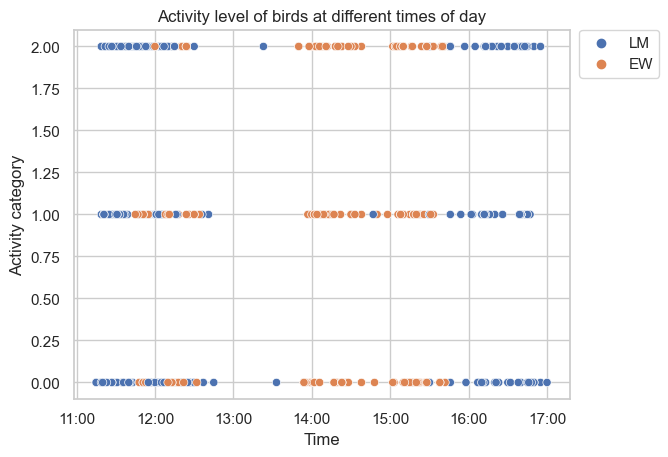

In [9]:
plot=sns.scatterplot(data=df_clean,x="Time",y="Activity",hue="Location")
plt.xlabel("Time")
plt.ylabel("Activity category")
plot.set_xticks(ticks=plot.get_xticks(),labels=(["11:00","12:00","13:00","14:00","15:00","16:00","17:00"]))
plt.title("Activity level of birds at different times of day")
plt.legend(bbox_to_anchor=(1.02,1),loc="upper left",borderaxespad=0)
plt.show()

Each dot in the graph shows the activity type of a given bird at a given time, and two things immediately spring out:

1. There are possibly some differences in activity type over time, especially in the afternoon, but the differences are likely minimal.
2. The observations are split into two very discrete groups with only a small number of real outliers - this will be potentially useful later.

Adding the `hue` argument also showed us something that will become important later: there is a stark difference in both the number and timespan of observations between both sites.

Interpreting differences in behaviour between the locations is difficult with this plot, but, bearing the above in mind, now let's have a look at the location. For this we will import the Contingency table on the other sheet of the Excel file.

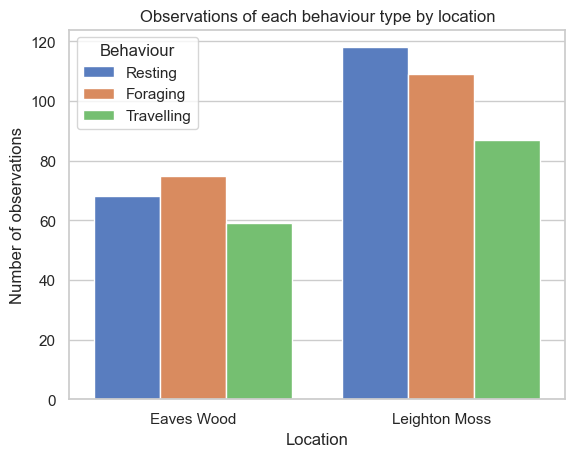

In [11]:
#Importing the data and preparing for plotting

Path2= "/Users/lukenash1/Documents/Finance/Projects/Bird Data Regression/Lancs Behaviour Data Contingency.csv"
df2= pd.read_csv(Path2)
df2_clean= df2.drop(df2.columns [[1,5]],axis=1)
group_list=["Resting","Foraging","Travelling"]
df2_barchart= df2.groupby('Location')[group_list].sum() #Generating sums grouped by Location and Behaviour
df2_barchart= df2_barchart.reset_index() #Location was imported as the index, so we corrected this here
df2_barchart= pd.melt(df2_barchart, id_vars="Location",var_name="Behaviour",value_name="Count") #Changing the format to enable plotting

#Creating the plot
sns.barplot(data= df2_barchart, x= "Location", y="Count",hue="Behaviour",palette="muted")
plt.xlabel("Location")
plt.ylabel("Number of observations")
plt.title("Observations of each behaviour type by location")
plt.show()

The effect of this variable is much more stark: while the total number of observations at each site skews the absolute values, you can see that a higher relative proportion of the birds at Leighton Moss engaged in resting behaviour compared to those at Eaves Wood, and consequently the proportion of foraging birds was higher.

### Model Construction and Evaluation

We will now construct the model using the `LogisticRegression` function in the sklearn library.

In [12]:
model1= LogisticRegression(multi_class= "multinomial", solver="lbfgs")

With MLR there are various model evaluation procedures you can do. The one I've chosen is **repeated stratified k-fold cross-validation**, becuase it not only mitigates (partially) the effect of the imbalance present in the relative sample sizes across the two sites, but also enables multiple assessments of accuracy on the same dataset.

We can report the mean accuracy of each of the folds among all the repeats, and the standard deviation of these accuracy values.

Let's define and implement the model evaluation procedure here now. For the moment we are going to use a common standard default of 3 repeats of 10 folds.

In [51]:
#The following code needs all string values to be numerical, so we need to convert Location to numeric values...

def column_convert(df,column_name):
    c_array= df[column_name].values
    uniques= np.unique(c_array)
    map_to_int= {value: index for index, value in enumerate(uniques)}
    df[column_name]= df[column_name].map(map_to_int)
    return df

#Converting the columns
df_clean2 = df_clean.copy()
column_convert(df_clean2,"Location")
df_clean2["Time"] = df_clean2["Time"].astype(int)

#Define inputs
X1= df_clean2.iloc[:, [0,1]].values
y1= np.array(df_clean2['Activity'])

#Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.20,shuffle=False)

#Define evaluation procedure
cv1= RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)

#Implementation and evaluation
M1_accuracy= cross_val_score(model1,X1_train,y1_train,scoring="accuracy",cv=cv1,n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)'% (mean(M1_accuracy), std(M1_accuracy)))

Mean Accuracy: 0.369 (0.006)


~37% accuracy is pretty poor, although the small standard deviation means our model is at least *predictably* poor, and suggests that increasing the number of repeats or folds is unlikely to improve our model much. It does also mean we can answer our research question of whether time of day and site location affect bird behaviour, as the poor accuracy means that the predictive power of the model for this dataset is low, which means that a given behaviour cannot be accurately predicted from time of day and location alone, meaning these covariates are unlikely to have a significant impact.

So how can this model be improved instead? Well, we can now look at changing the model's construction.

### Model Improvement

There are two glaring issues with the protocol described above.

1. The data set is fairly heavily imbalanced, mainly with respect to the Location variable, which will absolutely affect how the model learns the decision boundary.
2. The scope of the research question prevents the inclusion of a potentially important covariate.

Let's address the second point to start with.

#### Parameter Selection

We're going to reintroduce the taxonomic grouping of the bird as a potential covariate. It's worth noting that the Family and Species variables are hierarchical, so we're only going to consider the Species to avoid potential multicollinearity. Research on inter-familial and intra-familial differences in bird behaviour also seems to indicate inter-specific differences being more marked - Grandeiro et al. (2006), for instance, showed this in the *Charadriidae* and *Scopolacidae* families<sup>[1]</sup>, both of which have representatives featured in our research.

Unfortunately, this does mean that we have to restart the data preparation process, including forming a new train-test split, which is not ideal as I would ideally want to compare the performance of the new dataset on the same data, but given how poorly our first model performed this is perhaps not a real issue.

In [72]:
#Reintegrating species and preparing the data for the model
df_ps = df_clean.join(df_removed_cols)
df_ps['Location'].replace(['LM','EW'],[0,1],inplace=True)
df_ps["Time"] = df_ps["Time"].astype(int)
df_ps= df_ps.drop(["Period","Family"],axis=1)
print(df_ps)

                    Time  Location  Activity  Species
0    1694348820000000000         0         0  Bittern
1    1694348820000000000         0         0  Bittern
2    1694347920000000000         0         0  Bittern
3    1694346900000000000         0         0  Bittern
4    1694347200000000000         0         0  Bittern
..                   ...       ...       ...      ...
511  1694347860000000000         1         1     Wren
512  1694359680000000000         1         2     Wren
513  1694359200000000000         1         1     Wren
514  1694360400000000000         1         2     Wren
515  1694347800000000000         1         0     Wren

[516 rows x 4 columns]


And now we just need to redefine the inputs, run the models on each of the outputs and compare the accuracies. We'll do this by defining an evaluation function, running each model evaluation and appending the results to an empty list which we can then plot using `pyplot`.

In [85]:
from scipy.stats import sem

#Convert species column to integer values
column_convert(df_ps,"Species")

#Redefine inputs
X2= df_ps.iloc[:, [0,1,3]].values
y2= np.array(df_ps['Activity'])

#Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.2,shuffle=False)

#Defining the function
def evaluate_input(val_X, val_Y):
    cv= cv1
    model= model1
    scores= cross_val_score(model,val_X,val_Y,scoring="accuracy",cv=cv,n_jobs=-1)
    return scores

#Results and model evaluation
M2_scores= evaluate_input(X2_train,y2_train)
print(f"Model accuracy (with species parameter): {mean(M2_scores):.3f} ({std(M2_scores):.3f})")

[[1694348820000000000                   0                   0]
 [1694348820000000000                   0                   0]
 [1694347920000000000                   0                   0]
 ...
 [1694359200000000000                   1                  69]
 [1694360400000000000                   1                  69]
 [1694347800000000000                   1                  69]]
Model accuracy (with species parameter): 0.369 (0.006)


Absolutely no improvement at all! For all future adjustments to the model we will include the Species as a covariate, although the increased error in the model accuracy in the Species model is a potentially important point to consider. 

Let's now move back to the first problem with our system as discussed earlier.

#### Imbalance Correction

We're going to use a procedure called **Synthetic Minority Oversampling TEchnique**, known more commonly as **SMOTE**. This procedure essentially oversamples minority classes in each predictor variable, thus mitigating the effects of the imbalance. Implementation is quite simple, but we will need the `imblearn` library.

In [86]:
print(df_ps)

                    Time  Location  Activity  Species
0    1694348820000000000         0         0        0
1    1694348820000000000         0         0        0
2    1694347920000000000         0         0        0
3    1694346900000000000         0         0        0
4    1694347200000000000         0         0        0
..                   ...       ...       ...      ...
511  1694347860000000000         1         1       69
512  1694359680000000000         1         2       69
513  1694359200000000000         1         1       69
514  1694360400000000000         1         2       69
515  1694347800000000000         1         0       69

[516 rows x 4 columns]


In [87]:
from imblearn.over_sampling import SMOTE

#Define inputs
oversample= SMOTE()
X3= df_ps.iloc[:,[0,1,3]]
y3= df_ps.iloc[:,[2]]

#Checking oversampling
df_SMOTE= oversample.fit_resample(X3,y3)
print(df_SMOTE)

(                    Time  Location  Species
0    1694348820000000000         0        0
1    1694348820000000000         0        0
2    1694347920000000000         0        0
3    1694346900000000000         0        0
4    1694347200000000000         0        0
..                   ...       ...      ...
553  1694346756714110976         1       58
554  1694359654945935872         1        3
555  1694359717977466624         1        3
556  1694345606387779840         0       47
557  1694349292666980864         0       44

[558 rows x 3 columns],      Activity
0           0
1           0
2           0
3           0
4           0
..        ...
553         0
554         0
555         0
556         1
557         1

[558 rows x 1 columns])


The length of our data frame has increased by just over 40 samples!

However, the authors of [the original paper introducing SMOTE](https://arxiv.org/abs/1106.1813) say that it's best combined with a method which randomly undersamples the majority class<sup>[2]</sup>. Fortuitously, `imblearn` has a function that helps us do that. To implement SMOTE and random undersampling on the same dataset, you join them together in one process called a *pipeline*. Here's how we do that.

In [88]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Pipeline creation
over= SMOTE()
under= RandomUnderSampler()
steps= [('o', over),('u',under),('model',model1)]
pipeline= Pipeline(steps=steps)

We now use the pipeline in our model evaluation, as shown below.

In [89]:
#Evaluating model with SMOTE and random undersampling

y3= np.array(y3)
M3_accuracy= cross_val_score(pipeline, X3, y3, scoring="accuracy",cv=cv1, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)'% (mean(M3_accuracy), std(M3_accuracy)))

Mean Accuracy: 0.283 (0.007)


That didn't go especially well, with our accuracy ***decreasing*** down to a pathetic ~28%. Let's see if doing one of each of the practices (instead of both of them) improves our previous best of 42%.

In [92]:
#Define the pipelines
steps_over= [('o',over),('model',model1)]
steps_under= [('u',under),('model',model1)]
pipeline_over= Pipeline(steps=steps_over)
pipeline_under= Pipeline(steps=steps_under)

#Define pipeline evaluation function

def evaluate_pipeline(pipeline_input):
    cv=cv1
    X= X3
    y= np.array(y3)
    scores= cross_val_score(pipeline_input,X,y,scoring="accuracy",cv=cv1,n_jobs=-1)
    return scores

#Evaluate pipelines and compare to other tactics
M_over_scores= evaluate_pipeline(pipeline_over)
M_under_scores= evaluate_pipeline(pipeline_under)
print('SMOTE only: %.3f (%.3f), Undersampling Only: %.3f (%.3f), Both Procedures: %.3f (%.3f), No sampling adjustment: %.3f (%.3f)'% 
      (mean(M_over_scores),std(M_over_scores),mean(M_under_scores),std(M_under_scores),
       mean(M3_accuracy), std(M3_accuracy),mean(M2_scores),std(M2_scores)))

SMOTE only: 0.283 (0.007), Undersampling Only: 0.283 (0.007), Both Procedures: 0.283 (0.007), No sampling adjustment: 0.369 (0.006)


As you may have noticed, with all the models regardless of their construction, the standard deviations in the accuracy scores are relatively high (~15-20% of the mean) across the board. Generally, when accuracy estimates have a high degree of variation, the sample size used in building the model is too small. Small sample sizes severely impacts a model's predictive accuracy because the model doesn't have enough data to be trained properly and thus can't make accurate predictions.

Ordinarily, I would go out and collect more data until the variation is reduced to a much lower amount and then perform further analyses; however, the scenario in question means that there is no more available data. 

The low number in general also leads me to believe that the data quality is poor. The README in the [GitHub repository for this project](https://github.com/LukeNash28/Bird-Data-Regression) goes into some details about some flaws in the protocol for collecting data involved in this analysis, as well as some covariates that could not be/were not accounted for in the collection.

### Conclusion

While the data quality and other issues with the collection protocol certainly mitigate the effectiveness of the model built during this analysis, this exercise was still useful in that it illustrated how machine learning techniques such as multinomial logistic regression can be used in ecology analytics. A classification algorithm with better quality data could be used to generate predictions about the classification of a categorical variable (e.g. a bird's behaviour) when all the other significant covariates are known, and the applications of models with high predictive power are extensive and far-reaching in the field of ecology. Consequently, further development of classification machine learning models is an extremely worthwhile potential avenue of investigation.

#### *References*

[1] Grandeiro, J., Dias, M., Martins, R. & Palmeirim, J., 2006. Variation in numbers and behaviour of waders during the tidal cycle: implications for the use of estuarine sediment flats. *Acta Oecologica*, Volume 29, pp. 293-300.

[2] Chawla, N.V., Bowyer, K.W., Hall, L.O. & Kegelmeyer, W.P., 2002. SMOTE: Synthetic Minority Over-sampling Technique. *Journal of Artificial Intelligence Research*, Volume 16, pp. 321-357.